## Trabalho - Segmentação

> Programa de Pós-Graduação em Engenharia Elétrica e de Computação

> Processamento Digital de Imagens

In [1]:
# Importação das bibliotecas
import numpy as np 
import cv2
from matplotlib import pyplot as plt
import os
import glob
import pathlib
from skimage import filters

In [2]:
def load_data(datadir):
    img_array = []
    path = os.path.join(datadir)
    path_list  = list(os.listdir(path))
    for img in path_list:
        img_array.append(cv2.imread(os.path.join(path, img)))
    return img_array

imgs_seg = load_data('imagens-cor-segmentacao')

#### Watershed

https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html

https://pyimagesearch.com/2015/11/02/watershed-opencv/

In [3]:
def watershed(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    markers = cv2.watershed(img,markers)
    img[markers == -1] = [255,0,0]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [8]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

def watershed2(image):
    # Generate an initial image with two overlapping circles
    x, y = np.indices((80, 80))
    x1, y1, x2, y2 = 28, 28, 44, 52
    r1, r2 = 16, 20
    mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
    mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
    image = np.logical_or(mask_circle1, mask_circle2)

    # Now we want to separate the two objects in image
    # Generate the markers as local maxima of the distance to the background
    distance = ndi.distance_transform_edt(image)
    coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=image)
    return labels


def watershed3(img):
    # Binarização Otsu (negativo)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
    threshold = filters.threshold_otsu(gray)
    binarized_img = (gray < threshold)*1
    binarized_img = binarized_img.astype('uint8')
    
    # Operação de abertura
    kernel_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    opening_ellipse = cv2.morphologyEx(binarized_img, cv2.MORPH_OPEN, kernel_ellipse, iterations = 2)
    
    # Operação de Dilatação
    dilate_ellipse = cv2.dilate(opening_ellipse, kernel_ellipse, iterations = 3)
    
    # Determinando a área do primeiro plano
    dist_transform = cv2.distanceTransform(opening_ellipse, cv2.DIST_L2,5)
    
    # Binarização Otsu
    threshold1 = filters.threshold_otsu(dist_transform)
    binarized_img1 = (dist_transform > threshold1)*1
    
    # Subtração das imagens
    binarized_img1 = np.uint8(binarized_img1)
    img_subtract = cv2.subtract(dilate_ellipse, binarized_img1)
    
    # Cria um marcador para rotular as regiões dos objetos e fundo.
    ret, markers = cv2.connectedComponents(binarized_img1)
    
    # Define o rótulo do fundo como 1
    markers = markers+1
    
    # Define o rótulo das regiões desconhecidas como 0
    markers[img_subtract==255] = 0
    markers = cv2.watershed(img, markers)
    
    # Aplica o watershed
    markers = cv2.watershed(img, markers)
    img[markers == -1] = [255,0,0]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    return img

### K-means
https://www.geeksforgeeks.org/image-segmentation-using-k-means-clustering/#:~:text=Let's%20see%20how%20does%20K,of%20each%20of%20the%20clusters.

In [5]:
from sklearn.cluster import KMeans

def kmeans(image):
    pixel_vals = image.reshape((-1,3))
    pixel_vals = np.float32(pixel_vals)
    checkpoint = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.9)
    k = 6
    retval, labels, centers = cv2.kmeans(pixel_vals, k, None, checkpoint, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    segmented_image = segmented_data.reshape((image.shape))
    return segmented_image

### Otsu

https://www.geeksforgeeks.org/python-thresholding-techniques-using-opencv-set-3-otsu-thresholding/

In [6]:
def otsu(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    threshold = filters.threshold_otsu(img)
    binarized_img = (img > threshold)*1
    return binarized_img
    #ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #return thresh1

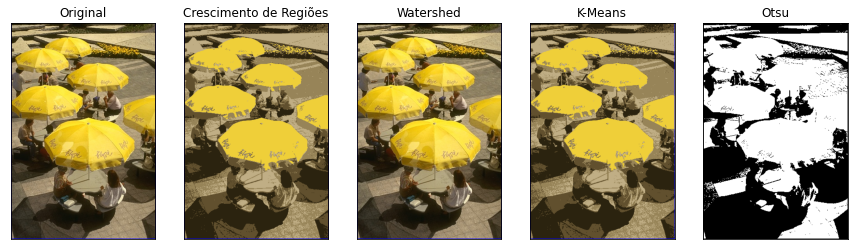

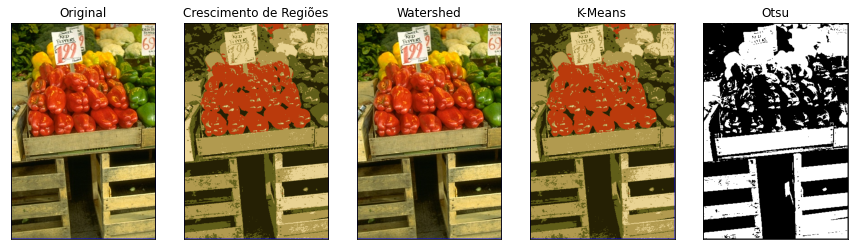

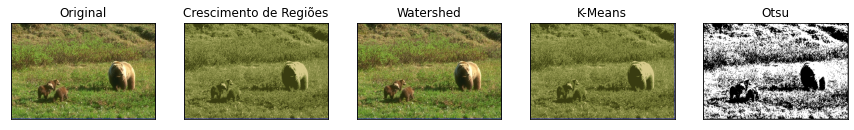

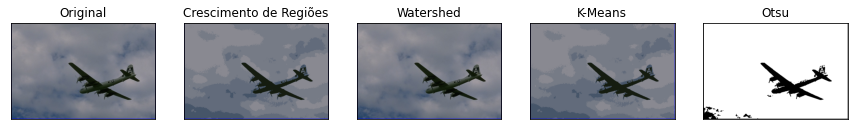

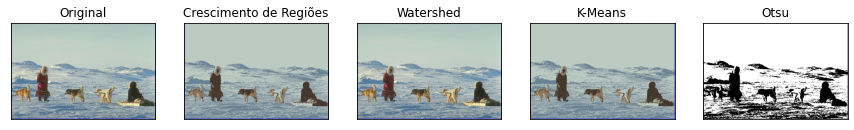

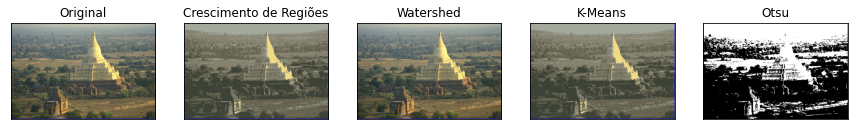

In [9]:
def plotImage(image, image_watershed, image_kmeans, image_otsu):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image_watershed = cv2.cvtColor(image_watershed, cv2.COLOR_BGR2RGB)
    image_kmeans = cv2.cvtColor(image_kmeans, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(15,12))
    
    plt.subplot(1, 5, 1), plt.imshow(image), plt.title("Original")
    plt.xticks([]), plt.yticks([])

    plt.subplot(1, 5, 2), plt.imshow(image_kmeans), plt.title("Crescimento de Regiões")
    plt.xticks([]), plt.yticks([])
    
    plt.subplot(1, 5, 3), plt.imshow(image_watershed), plt.title("Watershed")
    plt.xticks([]), plt.yticks([])
    
    plt.subplot(1, 5, 4), plt.imshow(image_kmeans), plt.title("K-Means")
    plt.xticks([]), plt.yticks([])
    
    plt.subplot(1, 5, 5), plt.imshow(image_otsu, cmap = "gray"), plt.title("Otsu")
    plt.xticks([]), plt.yticks([])
    plt.show()

for image in imgs_seg:
    image_watershed = watershed3(image)
    image_kmeans = kmeans(image)
    image_otsu = otsu(image)
    plotImage(image, image_watershed, image_kmeans, image_otsu)
